In [149]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import Transformer
from pykrige.ok import OrdinaryKriging
from scipy.interpolate import griddata
import xarray as xr
import matplotlib.pyplot as plt

In [150]:
df = pd.read_excel("dataframe_com_residuos.xlsx")
print(df.head())

   Unnamed: 0.1  Unnamed: 0       Data     3763_long       3763_lat  \
0             0           0 2018-06-20 -41240.983793  147938.005060   
1             1           1 2018-06-20 -66272.452636 -126138.602836   
2             2           2 2018-06-20 -43558.434663  107718.402059   
3             3           3 2018-06-20 -88100.749963 -104660.100318   
4             4           4 2018-06-20 -35388.726933  158867.677319   

   Estacao id               Estacao       pm10  pm10_weighted  \
0        1054          Anta-Espinho  13.681818      20.646031   
1        3093                 Arcos  36.491667      32.937641   
2        2017                Aveiro  27.125000      18.858698   
3        3075  Avenida da Liberdade  48.416667      32.890849   
4        1053               Avintes  27.200000      21.891247   

  Uso_solo_simplificado_500m  Urbanizado  Transporte  urban_pm10w  \
0                     Outros           0           0     0.000000   
1                 Urbanizado           1    

In [151]:
x = df["3763_long"]
y = df["3763_lat"]
residuals = df["residuals"].values


In [152]:
"""transformer = Transformer.from_crs("EPSG:4326", "EPSG:3763", always_xy=True)

xmin_lon, ymin_lat, xmax_lon, ymax_lat = -10, 36.5, -6.1, 43

xmin_3763, ymin_3763 = transformer.transform(xmin_lon, ymin_lat)
xmax_3763, ymax_3763 = transformer.transform(xmax_lon, ymax_lat)"""

'transformer = Transformer.from_crs("EPSG:4326", "EPSG:3763", always_xy=True)\n\nxmin_lon, ymin_lat, xmax_lon, ymax_lat = -10, 36.5, -6.1, 43\n\nxmin_3763, ymin_3763 = transformer.transform(xmin_lon, ymin_lat)\nxmax_3763, ymax_3763 = transformer.transform(xmax_lon, ymax_lat)'

In [153]:
"""gridx = np.arange(xmin_3763, xmax_3763, 2000)
gridy = np.arange(ymin_3763, ymax_3763, 2000)"""



'gridx = np.arange(xmin_3763, xmax_3763, 2000)\ngridy = np.arange(ymin_3763, ymax_3763, 2000)'

In [154]:
"""OK = OrdinaryKriging(
    x, y, residuals,
    variogram_model="spherical",
    verbose=False,
    enable_plotting=False
)

kriged_residuals, _ = OK.execute("grid", gridx, gridy)"""

'OK = OrdinaryKriging(\n    x, y, residuals,\n    variogram_model="spherical",\n    verbose=False,\n    enable_plotting=False\n)\n\nkriged_residuals, _ = OK.execute("grid", gridx, gridy)'

In [155]:
"""points = np.column_stack((x, y))
values = df["lasso_pm10"].values

grid_x, grid_y = np.meshgrid(gridx, gridy)
grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

lasso_grid = griddata(points, values, grid_points, method="linear")
lasso_grid = lasso_grid.reshape(grid_x.shape)"""

'points = np.column_stack((x, y))\nvalues = df["lasso_pm10"].values\n\ngrid_x, grid_y = np.meshgrid(gridx, gridy)\ngrid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))\n\nlasso_grid = griddata(points, values, grid_points, method="linear")\nlasso_grid = lasso_grid.reshape(grid_x.shape)'

In [156]:
"""final_pm10_grid = lasso_grid + kriged_residuals"""


'final_pm10_grid = lasso_grid + kriged_residuals'

In [157]:
ds = xr.open_dataset("cams/PM10_daymean_2018.nc")  # or whatever the filename is
cams_lons = ds.lon.values  # shape: (40,)
cams_lats = ds.lat.values  # shape: (66,)
grid_lon, grid_lat = np.meshgrid(cams_lons, cams_lats)

In [169]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3763", always_xy=True)
grid_x_flat, grid_y_flat = transformer.transform(grid_lon.ravel(), grid_lat.ravel())

# Reshape back to grid shape
grid_x_3763 = grid_x_flat.reshape(grid_lon.shape)
grid_y_3763 = grid_y_flat.reshape(grid_lat.shape)

In [170]:
OK = OrdinaryKriging(x, y, residuals, variogram_model="spherical", verbose=False)
residuals_interp, _ = OK.execute("points", grid_x_3763.ravel(), grid_y_3763.ravel())
residuals_interp = residuals_interp.reshape(grid_lon.shape)

In [171]:
lasso_points = np.column_stack((x, y))  # x, y in EPSG:3763
lasso_values = df["lasso_pm10"].values

# Target grid (already reprojected to EPSG:3763)
target_points = np.column_stack((grid_x_3763.ravel(), grid_y_3763.ravel()))

# Interpolate using linear method
lasso_interp = griddata(
    lasso_points,
    lasso_values,
    target_points,
    method="linear"
)
lasso_interp = lasso_interp.reshape(grid_x_3763.shape)
lasso_interp_filled = griddata(
    lasso_points,
    lasso_values,
    target_points,
    method="nearest"
).reshape(grid_x_3763.shape)



In [172]:
final_pm10_grid = lasso_interp + residuals_interp

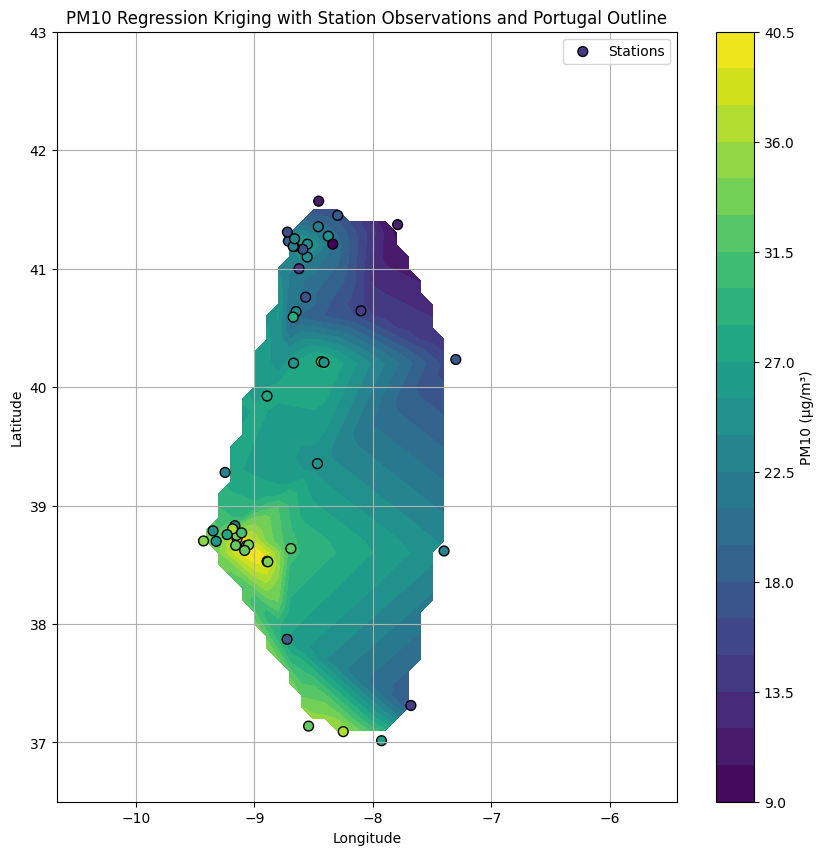

In [178]:

from pyproj import Transformer
import matplotlib.pyplot as plt

# === Reproject CAMS grid properly ===
transformer_grid = Transformer.from_crs("EPSG:4326", "EPSG:3763", always_xy=True)
grid_x_flat, grid_y_flat = transformer_grid.transform(grid_lon.ravel(), grid_lat.ravel())
grid_x_3763 = grid_x_flat.reshape(grid_lon.shape)
grid_y_3763 = grid_y_flat.reshape(grid_lat.shape)

# === Reproject station coordinates (EPSG:3763 to WGS84) ===
transformer_pts = Transformer.from_crs("EPSG:3763", "EPSG:4326", always_xy=True)
df["lon"], df["lat"] = transformer_pts.transform(df["3763_long"].values, df["3763_lat"].values)

# === Define Portugal bounding box in WGS84 and reproject to EPSG:3763 ===
bbox_lon = [-9.6, -6.2]
bbox_lat = [36.9, 42.2]
xmin, ymin = transformer_grid.transform(bbox_lon[0], bbox_lat[0])
xmax, ymax = transformer_grid.transform(bbox_lon[1], bbox_lat[1])

# === Plot kriging map with station points and bounding box ===
plt.figure(figsize=(10, 10))

# Plot kriged PM10 surface
contour = plt.contourf(grid_lon, grid_lat, final_pm10_grid, cmap="viridis", levels=20)
plt.colorbar(contour, label="PM10 (μg/m³)")

# Plot reprojected station points (now in lat/lon)
plt.scatter(df["lon"], df["lat"], c=df["pm10"], edgecolor="k", cmap="viridis", s=50, label="Stations")

# Plot bounding box as outline in lat/lon
bbox_lons = [bbox_lon[0], bbox_lon[1], bbox_lon[1], bbox_lon[0], bbox_lon[0]]
bbox_lats = [bbox_lat[0], bbox_lat[0], bbox_lat[1], bbox_lat[1], bbox_lat[0]]
#plt.plot(bbox_lons, bbox_lats, color="black", linestyle="--", label="Portugal bounding box")

plt.title("PM10 Regression Kriging with Station Observations and Portugal Outline")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


In [174]:
lisbon_idx = df["pm10"].idxmax()  # Or use a known station ID
print(df.loc[lisbon_idx, ["3763_long", "3763_lat", "lon", "lat"]])


3763_long    -88100.749963
3763_lat    -104660.100318
lon              -9.146152
lat              38.721149
Name: 3, dtype: object


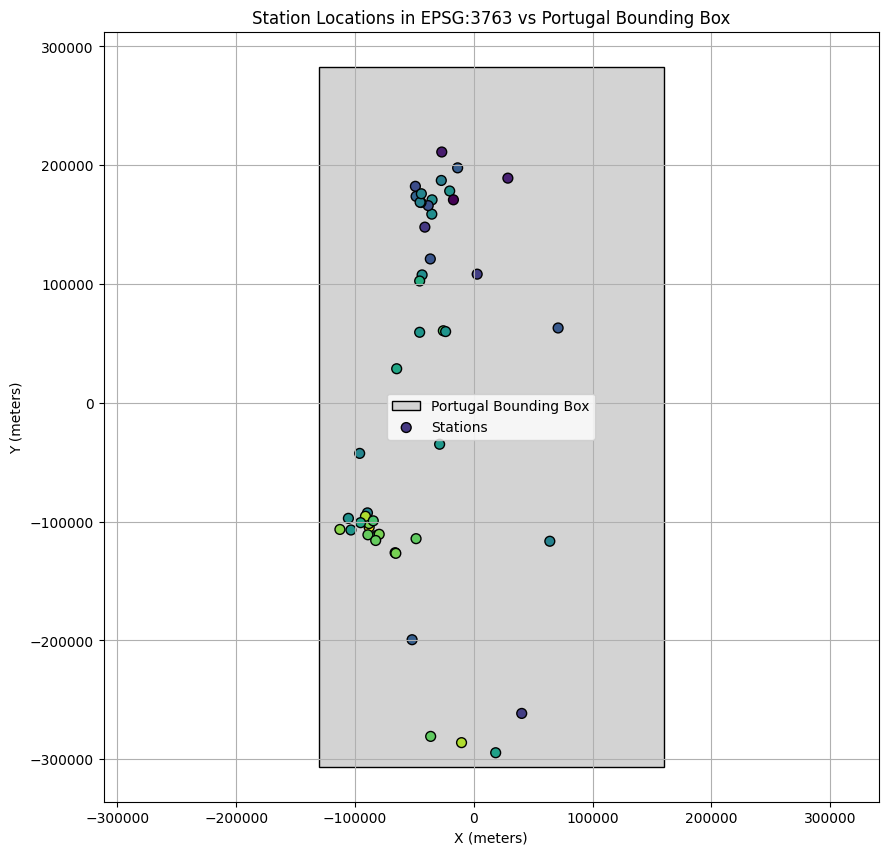

In [175]:
from pyproj import Transformer
import matplotlib.pyplot as plt

# Define a rough bounding box for Portugal in WGS84
lon_bounds = [-9.6, -6.2]
lat_bounds = [36.9, 42.2]

# Transform corners to EPSG:3763
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3763", always_xy=True)
xmin, ymin = transformer.transform(lon_bounds[0], lat_bounds[0])
xmax, ymax = transformer.transform(lon_bounds[1], lat_bounds[1])

# Plot simulated rectangle for Portugal
plt.figure(figsize=(10, 10))
plt.fill(
    [xmin, xmax, xmax, xmin, xmin],
    [ymin, ymin, ymax, ymax, ymin],
    facecolor='lightgray',
    edgecolor='black',
    label="Portugal Bounding Box"
)

# Plot station points in EPSG:3763
plt.scatter(df["3763_long"], df["3763_lat"], c=df["pm10"], cmap="viridis", edgecolor="k", s=50, label="Stations")

plt.title("Station Locations in EPSG:3763 vs Portugal Bounding Box")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()
